In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option("display.max_columns", None)
import xgboost as xgb
from sklearn import tree
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, plot_confusion_matrix, fbeta_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import warnings

In [2]:
df_ppl = pd.read_csv('data/People.csv')
df_cars = pd.read_csv('data/Vehicles.csv')
df_crashes = pd.read_csv('data/Crashes.csv')
warnings.filterwarnings('ignore')

C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (12,13,20,21,22,23,24,25,26,27,29) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (19,21,40,41,42,44,48,49,50,53,55,58,59,61,71) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
# making column names lowercase for ease of work
df_crashes.columns = df_crashes.columns.str.strip().str.lower()
df_cars.columns = df_cars.columns.str.strip().str.lower()
df_ppl.columns = df_ppl.columns.str.strip().str.lower()

In [4]:
# converting crash_date to datetime for future dataset split
df_crashes['crash_date'] = pd.to_datetime(df_crashes['crash_date'])

In [5]:
# creating our injury column, the future y-target
df_crashes['injury'] = df_crashes['injuries_total'] >= 1
df_crashes['injury']= df_crashes['injury'].astype(int)

In [6]:
df_crashes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541142 entries, 0 to 541141
Data columns (total 50 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   crash_record_id                541142 non-null  object        
 1   rd_no                          536550 non-null  object        
 2   crash_date_est_i               41029 non-null   object        
 3   crash_date                     541142 non-null  datetime64[ns]
 4   posted_speed_limit             541142 non-null  int64         
 5   traffic_control_device         541142 non-null  object        
 6   device_condition               541142 non-null  object        
 7   weather_condition              541142 non-null  object        
 8   lighting_condition             541142 non-null  object        
 9   first_crash_type               541142 non-null  object        
 10  trafficway_type                541142 non-null  object        
 11  

In [7]:
# ensuring that we only have the drivers from df_ppl
ppl_in_ppl_df = df_ppl[(df_ppl.person_type == 'DRIVER')]

In [8]:
m1 = pd.merge(df_cars, ppl_in_ppl_df, how='left', on=['crash_record_id'])

In [9]:
m2 = pd.merge(m1, df_crashes, how='left', on=['crash_record_id'])

In [10]:
full_df = m2.drop_duplicates(subset=['crash_record_id'], keep='first')

In [11]:
full_df['first_crash_type'].value_counts()

REAR END                        127020
PARKED MOTOR VEHICLE            125965
SIDESWIPE SAME DIRECTION         82738
TURNING                          75594
ANGLE                            57514
FIXED OBJECT                     25144
PEDESTRIAN                       12317
PEDALCYCLIST                      7993
SIDESWIPE OPPOSITE DIRECTION      7903
OTHER OBJECT                      5198
HEAD ON                           4666
REAR TO FRONT                     3593
REAR TO SIDE                      2197
OTHER NONCOLLISION                1750
REAR TO REAR                       808
ANIMAL                             377
OVERTURNED                         323
TRAIN                               33
Name: first_crash_type, dtype: int64

In [12]:
# picking our columns
columns = ['crash_date', 'crash_record_id', 'crash_date_x', 'latitude', 'longitude', 'injury', 'crash_month', 'crash_hour', 
           'street_name', 'damage', 'hit_and_run_i', 'roadway_surface_cond', 'road_defect',
          'weather_condition', 'crash_day_of_week', 'driver_action', 'exceed_speed_limit_i',
          'prim_contributory_cause', 'first_crash_type']

In [13]:
full_df = full_df[columns]

In [14]:
# creating 1 and 0 variables for whether the accident occured during rush_hour
# rush_hour in Chicago is defined as: Monday-Friday, 7-9am and 3-7pm
# per the website the data was pulled from, Sunday = 1, so we need the days between 2-6
def rush_hour(time):
    if ((time >= 7 and time <= 9) or (time >= 15 and time <= 18)):
        return 1
    else:
        return 0
def rush_hour_day(day):
    if (day >= 2 and day <= 6):
        return 1
    else:
        return 0

full_df['rush_hour'] = (full_df['crash_hour'].apply(rush_hour) & full_df['crash_day_of_week'].apply(rush_hour_day))

In [15]:
# creating a dictionary of primary causes of an accident, simplified
cause_dict = {'FAILING TO YIELD RIGHT-OF-WAY': 'Breaking Rules of Road',
              'IMPROPER LANE USAGE': 'Breaking Rules of Road',
             'DISREGARDING TRAFFIC SIGNALS' : 'Breaking Rules of Road',
             'IMPROPER TURNING/NO SIGNAL': 'Breaking Rules of Road',
              'DISREGARDING STOP SIGN' : 'Breaking Rules of Road',
             'DISREGARDING OTHER TRAFFIC SIGNS': 'Breaking Rules of Road',
             'DISREGARDING ROAD MARKINGS': 'Breaking Rules of Road',
             'DISREGARDING YIELD SIGN': 'Breaking Rules of Road',
             'PASSING STOPPED SCHOOL BUS': 'Breaking Rules of Road',
             'TURNING RIGHT ON RED': 'Breaking Rules of Road',
              'FAILING TO REDUCE SPEED TO AVOID CRASH': 'Speed Related',
              'EXCEEDING AUTHORIZED SPEED LIMIT': 'Speed Related',
              'EXCEEDING SAFE SPEED FOR CONDITIONS': 'Speed Related',
              'FOLLOWING TOO CLOSELY': 'Reckless/Poor Driving',
              'IMPROPER OVERTAKING/PASSING': 'Reckless/Poor Driving',
              'IMPROPER BACKING': 'Reckless/Poor Driving',
              'DRIVING SKILLS/KNOWLEDGE/EXPERIENCE': 'Reckless/Poor Driving',
              'OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER': 'Reckless/Poor Driving',
              'DRIVING ON WRONG SIDE/WRONG WAY': 'Reckless/Poor Driving',
              'UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN ARREST IS EFFECTED)': 'Drug/Alcohol Related',
              'HAD BEEN DRINKING (USE WHEN ARREST IS NOT MADE)': 'Drug/Alcohol Related',
              'PHYSICAL CONDITION OF DRIVER': 'Reckless/Poor Driving',
              'DISTRACTION - FROM INSIDE VEHICLE':'Distracted Driving',
              'CELL PHONE USE OTHER THAN TEXTING':'Distracted Driving',
              'TEXTING':'Distracted Driving',
              'DISTRACTION - OTHER ELECTRONIC DEVICE (NAVIGATION DEVICE, DVD PLAYER, ETC.)':'Distracted Driving',
              'WEATHER':"Outside World/Out of Drivers Control",
              'EQUIPMENT - VEHICLE CONDITION':"Outside World/Out of Drivers Control",
              'VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)':"Outside World/Out of Drivers Control",
              'DISTRACTION - FROM OUTSIDE VEHICLE':"Outside World/Out of Drivers Control",
              'ROAD ENGINEERING/SURFACE/MARKING DEFECTS':"Outside World/Out of Drivers Control",
              'ROAD CONSTRUCTION/MAINTENANCE':"Outside World/Out of Drivers Control",
              'ANIMAL':"Outside World/Out of Drivers Control",
              'EQUIPMENT - VEHICLE CONDITION': "Outside World/Out of Drivers Control",
              'EVASIVE ACTION DUE TO ANIMAL, OBJECT, NONMOTORIST':"Outside World/Out of Drivers Control",
              'MOTORCYCLE ADVANCING LEGALLY ON RED LIGHT':"Outside World/Out of Drivers Control",
              'BICYCLE ADVANCING LEGALLY ON RED LIGHT':"Outside World/Out of Drivers Control",
              'UNABLE TO DETERMINE': 'Other/Unknown',
              'NOT APPLICABLE': 'Other/Unknown',
              'OBSTRUCTED CROSSWALKS': 'Other/Unknown',
              'BICYCLE ADVANCING LEGALLY ON RED LIGHT': 'Other/Unknown',
              'RELATED TO BUS STOP': 'Other/Unknown',
             'MOTORCYCLE ADVANCING LEGALLY ON RED LIGHT': 'Other/Unknown'}

In [16]:
weather_dict = {'CLEAR': 'neutral',
                'RAIN': 'bad',
                'SNOW': 'bad',
                'CLOUDY/OVERCAST': 'neutral',
                'FOG/SMOKE/HAZE': 'vision_obstruction',
                'SLEET/HAIL': 'extreme',
                'FREEZING RAIN/DRIZZLE': 'extreme',
                'BLOWING SNOW': 'vision_obstruction',
                'SEVERE CROSS WIND GATE': 'extreme',
                'BLOWING SAND, SOIL, DIRT': 'vision_obstruction'
}

In [17]:
full_df['simple_reason'] = full_df['prim_contributory_cause'].map(cause_dict)
full_df['weather_condition'] = full_df['weather_condition'].map(weather_dict)

In [18]:
full_df = pd.get_dummies(full_df, columns=['simple_reason', 'weather_condition', 'first_crash_type'])

In [19]:
# 1s and 0s for road_defects
def defect(road):
    if road == 'NO DEFECTS':
        return 0
    else:
        return 1
    
full_df['road_defect'] = (full_df['road_defect'].apply(defect))

In [20]:
# got rid of any "unknown" road_defects
full_df = full_df[full_df.road_defect != 'UNKNOWN']

In [21]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 541133 entries, 0 to 1960927
Data columns (total 47 columns):
 #   Column                                              Non-Null Count   Dtype         
---  ------                                              --------------   -----         
 0   crash_date                                          541133 non-null  datetime64[ns]
 1   crash_record_id                                     541133 non-null  object        
 2   crash_date_x                                        541133 non-null  object        
 3   latitude                                            538017 non-null  float64       
 4   longitude                                           538017 non-null  float64       
 5   injury                                              541133 non-null  int32         
 6   crash_month                                         541133 non-null  int64         
 7   crash_hour                                          541133 non-null  int64        

In [22]:
full_df2 = full_df.drop(labels = ['crash_record_id','crash_date_x','latitude','longitude', 'street_name',
                       'damage','exceed_speed_limit_i', 'prim_contributory_cause', 'hit_and_run_i', 'crash_hour',
                        'crash_month', 'roadway_surface_cond', 'crash_day_of_week', 'driver_action', 'first_crash_type_OTHER NONCOLLISION', 'simple_reason_Other/Unknown'], axis=1)

#### Splitting df into old and new ####

In [23]:
old_df = (full_df2[full_df2['crash_date'] < '2018-12-31 12:59:59'])
new_df = (full_df2[full_df2['crash_date'] >= '2019-01-01 00:00:00'])

In [24]:
print(old_df.info())
print("""
      """)
print(new_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 256601 entries, 6 to 1784402
Data columns (total 31 columns):
 #   Column                                              Non-Null Count   Dtype         
---  ------                                              --------------   -----         
 0   crash_date                                          256601 non-null  datetime64[ns]
 1   injury                                              256601 non-null  int32         
 2   road_defect                                         256601 non-null  int64         
 3   rush_hour                                           256601 non-null  int64         
 4   simple_reason_Breaking Rules of Road                256601 non-null  uint8         
 5   simple_reason_Distracted Driving                    256601 non-null  uint8         
 6   simple_reason_Drug/Alcohol Related                  256601 non-null  uint8         
 7   simple_reason_Outside World/Out of Drivers Control  256601 non-null  uint8        

In [25]:
corr = new_df.corr()
corr

,injury,road_defect,rush_hour,simple_reason_Breaking Rules of Road,simple_reason_Distracted Driving,simple_reason_Drug/Alcohol Related,simple_reason_Outside World/Out of Drivers Control,simple_reason_Reckless/Poor Driving,simple_reason_Speed Related,weather_condition_bad,weather_condition_extreme,weather_condition_neutral,weather_condition_vision_obstruction,first_crash_type_ANGLE,first_crash_type_ANIMAL,first_crash_type_FIXED OBJECT,first_crash_type_HEAD ON,first_crash_type_OTHER OBJECT,first_crash_type_OVERTURNED,first_crash_type_PARKED MOTOR VEHICLE,first_crash_type_PEDALCYCLIST,first_crash_type_PEDESTRIAN,first_crash_type_REAR END,first_crash_type_REAR TO FRONT,first_crash_type_REAR TO REAR,first_crash_type_REAR TO SIDE,first_crash_type_SIDESWIPE OPPOSITE DIRECTION,first_crash_type_SIDESWIPE SAME DIRECTION,first_crash_type_TRAIN,first_crash_type_TURNING
injury,1.000000,-0.027304,-0.015651,0.118960,0.018741,0.034489,0.011612,-0.048360,0.059722,0.010434,0.003754,0.021018,0.004094,0.090981,-0.007373,0.019703,0.052311,-0.008653,0.022200,-0.174288,0.199481,0.322545,-0.005711,-0.031967,-0.020049,-0.019379,-0.009413,-0.104586,0.006234,0.030684
road_defect,-0.027304,1.000000,-0.015769,-0.068151,-0.016978,-0.013003,0.030683,-0.043446,-0.018565,0.020591,0.002983,-0.184726,0.005495,-0.019029,0.000686,0.014086,-0.003531,0.045472,0.001441,0.019163,-0.007045,-0.001141,-0.001205,0.003767,0.000291,0.005291,-0.000484,-0.007599,-0.000081,-0.028407
rush_hour,-0.015651,-0.015769,1.000000,0.021743,-0.009570,-0.036157,-0.001492,0.027493,-0.013769,-0.014451,-0.004435,0.027048,0.000347,0.002606,-0.000742,-0.052496,-0.011405,-0.015148,-0.007268,-0.082710,0.020124,0.007780,0.054743,-0.003793,-0.003414,-0.003660,-0.001616,0.045438,-0.003749,0.024717
simple_reason_Breaking Rules of Road,0.118960,-0.068151,0.021743,1.000000,-0.051570,-0.044088,-0.108362,-0.288227,-0.118685,-0.011346,-0.001321,0.051897,-0.005028,0.276897,-0.010117,-0.093817,-0.007197,-0.043767,-0.009917,-0.225886,0.046365,0.049061,-0.237520,-0.046121,-0.020826,-0.003738,-0.010753,0.070090,0.004928,0.310173
simple_reason_Distracted Driving,0.018741,-0.016978,-0.009570,-0.051570,1.000000,-0.008492,-0.020873,-0.055518,-0.022861,-0.011903,-0.003224,0.019553,0.002118,-0.021915,-0.002736,0.010928,0.007343,-0.002862,0.002693,0.010633,-0.003936,-0.004524,0.052462,-0.007447,-0.003982,-0.004725,-0.000622,-0.025620,-0.000897,-0.029805
simple_reason_Drug/Alcohol Related,0.034489,-0.013003,-0.036157,-0.044088,-0.008492,1.000000,-0.017845,-0.047464,-0.019545,0.000149,0.001542,0.007584,-0.000376,-0.017067,-0.002339,0.040422,0.020565,0.003126,0.003970,0.038254,-0.007529,-0.005082,-0.010437,-0.004801,-0.004549,-0.007045,0.007932,-0.022260,-0.000766,-0.023148
simple_reason_Outside World/Out of Drivers Control,0.011612,0.030683,-0.001492,-0.108362,-0.020873,-0.017845,1.000000,-0.116659,-0.048038,0.160058,0.038035,-0.133409,0.025708,-0.017550,0.072246,0.129409,0.009561,0.079156,0.014155,-0.009275,-0.003524,0.011146,-0.008276,-0.011609,-0.007888,-0.009873,0.001374,-0.049748,0.002015,-0.039191
simple_reason_Reckless/Poor Driving,-0.048360,-0.043446,0.027493,-0.288227,-0.055518,-0.047464,-0.116659,1.000000,-0.127773,-0.021991,-0.008622,0.055073,-0.003799,-0.128469,-0.014988,-0.034210,0.014521,-0.026996,-0.003675,-0.058283,-0.034590,-0.056859,0.244863,0.093413,0.022328,0.036258,0.009368,0.030541,-0.002251,-0.112515
simple_reason_Speed Related,0.059722,-0.018565,-0.013769,-0.118685,-0.022861,-0.019545,-0.048038,-0.127773,1.000000,0.022160,0.003007,-0.004600,-0.000137,-0.028448,-0.005119,0.016836,0.001188,-0.004217,0.001759,-0.033331,-0.011482,-0.004773,0.143196,-0.019016,-0.009214,-0.014160,-0.005975,-0.056277,0.003321,-0.035575
weather_condition_bad,0.010434,0.020591,-0.014451,-0.011346,-0.011903,0.000149,0.160058,-0.021991,0.022160,1.000000,-0.023031,-0.810204,-0.015185,0.009007,-0.003633,0.034924,0.009798,0.006644,0.003287,-0.030196,-0.020943,0.015660,0.028040,-0.006961,-0.006904,-0.008077,0.004755,-0.02751

In [26]:
X = new_df.drop(labels = ['injury', 'crash_date'], axis=1)
y = new_df['injury']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Logistical Regression

Random Forest

K Nearest Neighbor

Decision Tree

Gaussian Naive Bayes

XGBoost

In [28]:
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train)

y_pred = dummy_clf.predict(X_test)

baseline_cv = cross_val_score(dummy_clf, X_train, y_train, scoring="neg_root_mean_squared_error")


print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))     
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("FBeta", fbeta_score(y_test, y_pred, beta=0.5))
print("AUC", roc_auc_score(y_test, y_pred))
print("CVS", -(baseline_cv.mean()))

Accuracy: 0.7487758203410818
Precision: 0.1450608412379036
Recall: 0.14494973671613212
F1: 0.14500526769466526
FBeta 0.14503860670971203
AUC 0.49888068793149526
CVS 0.49878738304222037


In [29]:
pipeline_lr = Pipeline([('scalar1',StandardScaler()),
                       ('pca1',PCA(n_components=2)),
                       ('lr_classifier', LogisticRegression(random_state=42))])

pipeline_dt = Pipeline([('scalar2', StandardScaler()),
                        ('pca2',PCA(n_components=2)),
                        ('dt_classifier', DecisionTreeClassifier())])

pipeline_rf = Pipeline([('scalar3', StandardScaler()),
                       ('pca3', PCA(n_components=2)),
                       ('rf_classifier', RandomForestClassifier())])

pipeline_knn = Pipeline([('scalar4', StandardScaler()),
                        ('pca4', PCA(n_components=2)),
                        ('knn_classifier', KNeighborsClassifier())])

pipeline_gnb = Pipeline([('scalar5', StandardScaler()),
                        ('pca5', PCA(n_components=2)),
                        ('gnb_classifier', GaussianNB())])

pipeline_xgb = Pipeline([('scalar6', StandardScaler()),
                        ('pca6', PCA(n_components=20)),
                        ('xgb_classifier', GradientBoostingClassifier())])

In [30]:
pipelines = [pipeline_lr, pipeline_dt, pipeline_rf, pipeline_knn, pipeline_gnb, pipeline_xgb]

In [31]:
best_accuracy = 0.0
best_classifier = 0
best_pipeline = ""

In [32]:
pipe_dict = {0: 'Logistic Regression', 1: 'Decision Tree', 2: 'RandomForest', 3: 'KNearestNeighbors', 4: 'Gaussian Naive Bayes',
            5: 'XGBClassifier'}

for pipe in pipelines:
    pipe.fit(X_train, y_train)

In [33]:
for i, model in enumerate(pipelines):
    print("{} Test Accuracy: {}".format(pipe_dict[i], model.score(X_test, y_test)))

Logistic Regression Test Accuracy: 0.8530280857770023
Decision Tree Test Accuracy: 0.8098581640119322
RandomForest Test Accuracy: 0.8691394157708111
KNearestNeighbors Test Accuracy: 0.8700681037879214
Gaussian Naive Bayes Test Accuracy: 0.8530280857770023
XGBClassifier Test Accuracy: 0.8771317611301852


In [34]:
for i, model in enumerate(pipelines):
    if model.score(X_test, y_test) > best_accuracy:
        best_accuracy = model.score(X_test, y_test)
        best_pipeline=model
        best_classifier=i
print('Classifier with best accuracy: {}'.format(pipe_dict[best_classifier]))

Classifier with best accuracy: XGBClassifier


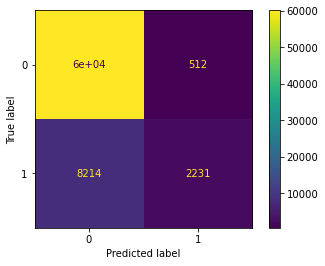

In [35]:
xgb = GradientBoostingClassifier(random_state=42)
xgb.fit(X_train, y_train)
plot_confusion_matrix(xgb, X_test, y_test);

In [36]:
# SMOTE that data!

# standardizing the data
scaler=StandardScaler()

X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [37]:
smote_pipeline_lr = Pipeline([('scalar1',StandardScaler()),
                       ('pca1',PCA(n_components=2)),
                       ('lr_classifier', LogisticRegression(random_state=42))])

smote_pipeline_dt = Pipeline([('scalar2', StandardScaler()),
                        ('pca2',PCA(n_components=2)),
                        ('dt_classifier', DecisionTreeClassifier())])

smote_pipeline_rf = Pipeline([('scalar3', StandardScaler()),
                       ('pca3', PCA(n_components=2)),
                       ('rf_classifier', RandomForestClassifier())])

smote_pipeline_knn = Pipeline([('scalar4', StandardScaler()),
                        ('pca4', PCA(n_components=2)),
                        ('knn_classifier', KNeighborsClassifier())])

smote_pipeline_gnb = Pipeline([('scalar5', StandardScaler()),
                        ('pca5', PCA(n_components=2)),
                        ('gnb_classifier', GaussianNB())])

smote_pipeline_xgb = Pipeline([('scalar6', StandardScaler()),
                        ('pca6', PCA(n_components=20)),
                        ('xgb_classifier', GradientBoostingClassifier())])

In [38]:
SMOTE_pipelines = [smote_pipeline_lr, smote_pipeline_dt, smote_pipeline_rf,
                   smote_pipeline_knn, smote_pipeline_gnb, smote_pipeline_xgb]

In [39]:
smote_pipe_dict = {0: 'SMOTE Logistic Regression', 1: 'SMOTE Decision Tree', 2: 'SMOTE RandomForest',
             3: 'SMOTE KNearestNeighbors', 4: 'SMOTE Gaussian Naive Bayes', 5: 'SMOTE XGBClassifier'}

for pipe in SMOTE_pipelines:
    pipe.fit(X_train, y_train)

In [40]:
smote_model_acc_scores = []
for i, model in enumerate(pipelines):
    smote_model_acc_scores.append((smote_pipe_dict[i], model.score(X_test, y_test)))
    print("{} Test Accuracy: {}".format(smote_pipe_dict[i], model.score(X_test, y_test)))

SMOTE Logistic Regression Test Accuracy: 0.830415939663421
SMOTE Decision Tree Test Accuracy: 0.8255332920583104
SMOTE RandomForest Test Accuracy: 0.8058197782405584
SMOTE KNearestNeighbors Test Accuracy: 0.8510299994371587
SMOTE Gaussian Naive Bayes Test Accuracy: 0.7508583328642989
SMOTE XGBClassifier Test Accuracy: 0.805904204423932


In [41]:
smote_model_acc_scores.sort()
smote_model_acc_scores

[('SMOTE Decision Tree', 0.8255332920583104),
 ('SMOTE Gaussian Naive Bayes', 0.7508583328642989),
 ('SMOTE KNearestNeighbors', 0.8510299994371587),
 ('SMOTE Logistic Regression', 0.830415939663421),
 ('SMOTE RandomForest', 0.8058197782405584),
 ('SMOTE XGBClassifier', 0.805904204423932)]

In [42]:
for i, model in enumerate(SMOTE_pipelines):
    if model.score(X_test, y_test) > best_accuracy:
        best_accuracy = model.score(X_test, y_test)
        best_pipeline=model
        best_classifier=i
print('Classifier with best accuracy: {}'.format(smote_pipe_dict[best_classifier]))

Classifier with best accuracy: SMOTE XGBClassifier


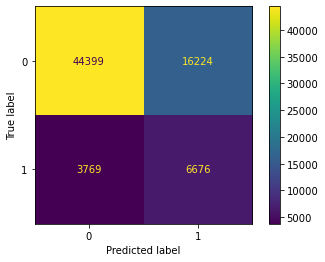

In [43]:
xgb = GradientBoostingClassifier(random_state=42)
xgb.fit(X_train, y_train)
plot_confusion_matrix(xgb, X_test, y_test);

#### XGBClassifier Model ####

In [44]:
grid_values = {}

grid = GridSearchCV(xgb, param_grid=grid_values)

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

baseline_cv = cross_val_score(grid, X_train, y_train, scoring="neg_root_mean_squared_error")

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))     
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("FBeta:", fbeta_score(y_test, y_pred, beta=0.5))
print("AUC", roc_auc_score(y_test, y_pred))
print("CVS", -(cross_val_score(xgb, X_train, y_train, scoring="neg_root_mean_squared_error").mean()))

Accuracy: 0.7186778859683683
Precision: 0.29152838427947597
Recall: 0.639157491622786
F1: 0.40041985305143196
FBeta: 0.32711058846587293
AUC 0.6857681458740755


NameError: name 'rand' is not defined

#### Logistic Regression Model ####

In [45]:
logreg = LogisticRegression(random_state=42)

grid_values = {}

grid = GridSearchCV(logreg, param_grid = grid_values)

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

baseline_cv = cross_val_score(grid, X_train, y_train, scoring="neg_root_mean_squared_error")

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))     
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("FBeta:", fbeta_score(y_test, y_pred, beta=0.5))
print("CVS:", -(baseline_cv.mean()))

Accuracy: 0.6837535881127934
Precision: 0.27191718489306843
Recall: 0.6865485878410723
F1: 0.38954830648885025
FBeta: 0.3092734596706719
CVS: 0.5580762339612014


In [46]:
logreg = LogisticRegression(random_state=42)

grid_values = {'C':[.0001,.001,.01,.1,1]}

grid = GridSearchCV(logreg, param_grid = grid_values)

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

baseline_cv = cross_val_score(grid, X_train, y_train, scoring="neg_root_mean_squared_error")

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))     
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("FBeta:", fbeta_score(y_test, y_pred, beta=0.5))
print("CVS:", -(baseline_cv.mean()))

Accuracy: 0.718410536387685
Precision: 0.2913959269111683
Recall: 0.6397319291527046
F1: 0.4004074784276126
FBeta: 0.3270072135383531
CVS: 0.5580589660838385


#### Gaussian Naive Bayes ####

In [47]:
gnb = GaussianNB()

gnb = gnb.fit(X_train, y_train)

grid_values = {}

grid = GridSearchCV(gnb, param_grid = grid_values)

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

baseline_cv = cross_val_score(grid, X_train, y_train, scoring="neg_root_mean_squared_error")

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))     
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("FBeta:", fbeta_score(y_test, y_pred, beta=0.5))
print("AUC:", roc_auc_score(y_test, y_pred))
print("CVS:", -(baseline_cv.mean()))

Accuracy: 0.7071114988461755
Precision: 0.28345305713331104
Recall: 0.6497845859262805
F1: 0.39471924161795924
FBeta: 0.31947543329473455
AUC: 0.6833865938060546
CVS: 0.5596517262035225


#### Random Forest Model ####

In [48]:
rand = RandomForestClassifier(random_state=42)

grid_values = {}

grid = GridSearchCV(rand, param_grid=grid_values)

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

baseline_cv = cross_val_score(grid, X_train, y_train, scoring="neg_root_mean_squared_error")

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))     
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("FBeta:", fbeta_score(y_test, y_pred, beta=0.5))
print("AUC", roc_auc_score(y_test, y_pred))
print("CVS", -(cross_val_score(rand, X_train, y_train, scoring="neg_root_mean_squared_error").mean()))

Accuracy: 0.724067090673721
Precision: 0.2954149738827626
Recall: 0.6335088559119196
F1: 0.4029350870783096
FBeta: 0.3307144070930918
AUC 0.6865893091066781
CVS 0.5503955692356444


In [49]:
rand = RandomForestClassifier(random_state=42)

grid_values = {'n_estimators' : [10], 'criterion' : ['entropy']}

grid = GridSearchCV(rand, param_grid=grid_values)

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

baseline_cv = cross_val_score(grid, X_train, y_train, scoring="neg_root_mean_squared_error")

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))     
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("FBeta:", fbeta_score(y_test, y_pred, beta=0.5))
print("AUC", roc_auc_score(y_test, y_pred))
print("CVS", -(cross_val_score(rand, X_train, y_train, scoring="neg_root_mean_squared_error").mean()))

Accuracy: 0.7238419541847245
Precision: 0.29518582965243384
Recall: 0.6334131163235998
F1: 0.40270253819465585
FBeta: 0.33047943494810034
AUC 0.6864177238909785
CVS 0.5503955692356444
